In [1]:
import numpy as np
import scipy.linalg as linalg
from numba import njit, prange
from pprint import pprint
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:


def FDExplicit(S0, K, r, T, div, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax):
    i_stock = np.arange(n_S_steps)
    j_time = np.arange(n_T_steps)
    grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1)) 
    S_slice = np.linspace(0, Smax, n_S_steps + 1)
    intrinsic_values = np.linspace(0, Smax, n_S_steps + 1)
    dt = T/float(n_T_steps)
         
    #setup intrinsic value
    if option_type == "call":
        intrinsic_values = np.maximum(S_slice - K, 0)
    elif option_type == "put":
        intrinsic_values = np.maximum(K - S_slice, 0)
    #setup final and boundary conditions
    if option_type == "call":
        # final condition
        grid[:, -1] = np.maximum(S_slice - K, 0.0)
        # upper BC for S
        if not is_european:
            grid[-1, :-1] = (Smax - K)
        else:
            grid[-1, :-1] = Smax*np.exp(-div*dt*(n_T_steps - j_time)) - \
                            K*np.exp(-r*dt*(n_T_steps - j_time))
    elif option_type == "put":
        # final condition
        grid[:, -1] = np.maximum(K - S_slice, 0.0)
        # lower BC for S
        if not is_european:
            grid[0, :-1] = K
        else:
            grid[0, :-1] = K*np.exp(-r*dt*(n_T_steps - j_time))
    else:         
        grid = 0.0
    
    #setup coefficients a, b and c 
    a = 0.5*dt*((sigma**2)*(i_stock**2) - (r - div)*i_stock)
    b = dt*((sigma**2)*(i_stock**2) + r)
    c = 0.5*dt*((sigma**2)*(i_stock**2) + (r - div)*i_stock)
    
    # iterate grid backward
    for j in reversed(j_time):
        for i in range(n_S_steps)[1:-1]:
            grid[i, j] = a[i]*grid[i - 1, j + 1] + \
                (1 - b[i])*grid[i, j + 1] + c[i]*grid[i + 1, j + 1]
        if not is_european:
            grid[:, j] = np.maximum(grid[:, j], intrinsic_values)
    return np.interp(S0, S_slice, grid[:, 0])
    
    
    
 

In [3]:


def FDImplicit_LU(S0, K, r, T, div, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax):
    i_stock = np.arange(n_S_steps)     
    j_time = np.arange(n_T_steps)     
    grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))     
    S_slice = np.linspace(0, Smax, n_S_steps + 1)     
    dt = T/float(n_T_steps)     
    #setup final and boundary conditions
    if option_type == "call":
        # final condition         
        grid[:, -1] = np.maximum(S_slice - K, 0.0)          
        # upper BC for S         
        if not is_european:
            grid[-1, :-1] = (Smax - K)
        else:
            grid[-1, :-1] = Smax*np.exp(-div*dt*(n_T_steps - j_time)) - \
                K*np.exp(-r*dt*(n_T_steps - j_time))

    elif option_type == "put":         
        # final condition         
        grid[:, -1] = np.maximum(K - S_slice, 0.0)         
        # lower BC for S        
        if not is_european:             
            grid[0, :-1] = K         
        else:
            grid[0, :-1] = K*np.exp(-r*dt*(n_T_steps - j_time))
    else:
        grid = 0.0
    #setup coefficients a, b and c     
    a = -0.5*dt*((sigma**2)*(i_stock**2) - (r - div)*i_stock)
    b = dt*((sigma**2)*(i_stock**2) + r)     
    c = -0.5*dt*((sigma**2)*(i_stock**2) + (r - div)*i_stock)     
    # matrix is a [n_S_steps -1, n_S_steps -1] 2D array.
    # only the interior of the grid needs be solved     
    matrix = np.diag(a[2:n_S_steps], -1) + np.diag(1 + b[1:n_S_steps]) + \
                      np.diag(c[1:n_S_steps - 1], 1)
    #iterate grid backward
    P, L, U = linalg.lu(matrix)
    edge = np.zeros(n_S_steps - 1)
    for j in reversed(range(n_T_steps)):
        edge[0] = -a[1]*grid[0, j]         
        edge[n_S_steps - 2] = -c[n_S_steps - 1]*grid[n_S_steps, j]         
        xL = linalg.solve(L, grid[1:n_S_steps, j + 1] + edge)         
        xU = linalg.solve(U, xL)         
        grid[1:n_S_steps, j] = xU     
        
    return np.interp(S0, S_slice, grid[:, 0])

In [4]:
#main program
S0 = 100
K = 110
T = 1.0
r = 0.02
q = 0.08
sigma = 0.3
option_type = "call"
is_european = True
n_T_steps = 10000
n_S_steps = 100
Smax = S0*3

option_FD_exp = FDExplicit(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax)

print(option_type + ' price_FD_Explicit =', option_FD_exp) 
n_T_steps = 100

option_FD_exp = FDExplicit(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax)

print(option_type + ' price_FD_Explicit =', option_FD_exp)

n_T_steps = 500

option_FD_exp = FDExplicit(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax)

print(option_type + ' price_FD_Explicit =', option_FD_exp)

# option_FD_imp_LU = FDImplicit_LU(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax)

# print(option_type + ' price_FD_Implicit_LU =', option_FD_imp_LU) 

# option_FD_imp_pSOR = FDImplicit_pSOR(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax)

# print(option_type + ' price_FD_Implicit_pSOR =', option_FD_imp_pSOR) 

call price_FD_Explicit = 5.719808514111214
call price_FD_Explicit = -1.4783442720689823e+66
call price_FD_Explicit = -2.2303032335771485e+117


In [13]:
def FD_CN(S0, K, r, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax):
    i_stock = np.arange(n_S_steps)     
    j_time = np.arange(n_T_steps)    
    grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))     
    S_slice = np.linspace(0, Smax, n_S_steps + 1)     
    intrinsic_values = np.linspace(0, Smax, n_S_steps + 1)     
    dt = T/float(n_T_steps)     
    #setup intrinsic value     
    if option_type == "call":         
        intrinsic_values = np.maximum(S_slice - K, 0)     
    elif option_type == "put":         
        intrinsic_values = np.maximum(K - S_slice, 0)     
    
    #setup final and boundary conditions     
    if option_type == "call":         
        # final condition         
        grid[:, -1] = np.maximum(S_slice - K, 0.0)
        # upper BC for S         
        if not is_european:             
            grid[-1, :-1] = (Smax - K)         
        else:             
            grid[-1, :-1] = Smax*np.exp(-div*dt*(n_T_steps - j_time)) - \
                K*np.exp(-r*dt*(n_T_steps - j_time))     
    
    elif option_type == "put":         
        # final condition         
        grid[:, -1] = np.maximum(K - S_slice, 0.0)         
        # lower BC for S         
        if not is_european:             
            grid[0, :-1] = K         
        else:             
            grid[0, :-1] = K*np.exp(-r*dt*(n_T_steps - j_time))     
    
    else:         
        grid = 0.0

    #setup coefficients a, b and c     
    a = -0.25*dt*((sigma**2)*(i_stock**2) - (r - div)*i_stock)     
    b = 0.5*dt*((sigma**2)*(i_stock**2) + r)     
    c = -0.25*dt*((sigma**2)*(i_stock**2) + (r - div)*i_stock)     
    # matrix is a [n_S_steps -1, n_S_steps -1] 2D array.     
    # only the interior of the grid needs be solved
    C_matrix = np.diag(a[2:n_S_steps], -1) + np.diag(1 - b[1:n_S_steps]) + np.diag(c[1:n_S_steps - 1], 1)
    D_matrix = np.diag(a[2:n_S_steps], -1) + np.diag(1 + b[1:n_S_steps]) + np.diag(c[1:n_S_steps - 1], 1)      

In [5]:
def FDImplicit_pSOR(S0, K, r, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier):    
    i_stock = np.arange(n_S_steps)     
    j_time = np.arange(n_T_steps)    
    grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))     
    theta_grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))
    if barrier == None:
        S_slice = np.linspace(0, Smax, n_S_steps + 1)
        intrinsic_values = np.linspace(0, Smax, n_S_steps + 1)

    elif barrier >= S0:
        raise IndexError('Barrier mus be lower than the current stock price')
    
    else:
        S_slice = np.linspace(barrier, Smax, n_S_steps + 1)
        intrinsic_values = np.linspace(barrier, Smax, n_S_steps + 1)

    dt = T/float(n_T_steps)     
    #setup intrinsic value     
    if option_type == "call":         
        intrinsic_values = np.maximum(S_slice - K, 0)     
    elif option_type == "put":         
        intrinsic_values = np.maximum(K - S_slice, 0)     
    
    #setup final and boundary conditions     --- payoff conditions 
    if option_type == "call":         
        # final condition         
        grid[:, -1] = np.maximum(S_slice - K, 0.0) # end conditions
        # upper BC for S         
        if not is_european:             
            grid[-1, :-1] = (Smax - K)         # american payoff
        else:             
            grid[-1, :-1] = Smax*np.exp(-div*dt*(n_T_steps - j_time)) - \
                K*np.exp(-r*dt*(n_T_steps - j_time))     # euro payoff if hits upper limit
    
    elif option_type == "put":         
        # final condition         
        grid[:, -1] = np.maximum(K - S_slice, 0.0)   # payoff at end      
        # lower BC for S         
        if not is_european:             
            grid[0, :-1] = K         # euro payoff if stock hits zero
        else:             
            grid[0, :-1] = K*np.exp(-r*dt*(n_T_steps - j_time))     # euro payoff if stock hits zero 
    
    else:         
        grid = 0.0     
    
    #setup coefficients a, b and c     --- these are vectors
    a = -0.5*dt*((sigma**2)*(i_stock**2) - (r - div)*i_stock)     
    b = dt*((sigma**2)*(i_stock**2) + r)     
    c = -0.5*dt*((sigma**2)*(i_stock**2) + (r - div)*i_stock)     
    # matrix is a [n_S_steps -1, n_S_steps -1] 2D array.     
    # only the interior of the grid needs be solved     
    matrix = np.diag(a[2:n_S_steps], -1) + np.diag(1 + b[1:n_S_steps]) + np.diag(c[1:n_S_steps - 1], 1)     
    #iterate grid backward     
    epsilon = 0.00001     # acceptable error
    k_max = 200     # number of x's to try in gauss-sidel
    # omega = 1.25           # averaging adjustment
    phi = np.copy(grid[1:n_S_steps, n_T_steps]) # vector thats the center of price but pulled from the end time
    # print(phi, grid[1:n_S_steps, n_T_steps-1])
    b = np.empty_like(phi)    
    b[:] = phi     # copy phi to b 
    for j in reversed(range(n_T_steps)):         # count backwards from max timesteps
        k = 0     # a counter    
        residual = 100.0         
        b[0] += -a[1]*grid[0, j]         # b value at stock price zero, at loop time
        b[n_S_steps - 2] += -c[n_S_steps - 1]*grid[n_S_steps, j]     
        # print(b)    # second from top price b value 
        while k < k_max and residual > epsilon:    # check to see if we are below our error threshold         
            phi_previous = np.copy(phi)             # save phi
            for i in range(n_S_steps - 1):                 # iterate through all prices
                # # sigma is a scalar
                # if i == 0:  # deal with edge values -- price == 0                   
                #     sigma = matrix[i][i + 1]*phi[i + 1]                 
                # elif i == n_S_steps - 2:     # deal with edge values --- price is effectively max                
                #     sigma = matrix[i][i - 1]*phi[i - 1]                 
                # else:                     
                #     sigma = matrix[i][i - 1]*phi[i - 1] + matrix[i][i + 1]*phi[i + 1]

                # phi[i] = (1 - omega)*phi[i] + (omega/matrix[i][i])*(b[i] - sigma)   

                try: phi[i] = SOR(phi, b[i], matrix[i][i-1], matrix[i][i], matrix[i][i+1], omega, i, n_S_steps-1)
                except: continue
                
                if not is_european:                     
                    phi[i] = max(phi[i], intrinsic_values[i + 1])             
                
            k += 1             
            residual = np.linalg.norm(phi - phi_previous)         
            
        grid[1:n_S_steps, j] = phi         
                                                                                         
        b[:] = phi

    return np.interp(S0, S_slice, grid[:, 0]), theta_value(grid, dt, S_slice, S0)

In [6]:
@njit
def SOR(x, b, mtrx_a, mtrx_b, mtrx_c, omega, counter, counter_max):
    if counter == 0:  # deal with edge values -- price == 0                   
                    summation_term = mtrx_c*x[counter+1]              
    elif counter == counter_max:     # deal with edge values --- price is effectively max                
                    summation_term = mtrx_a*x[counter-1]                 
    else:                     
        summation_term = mtrx_a*x[counter-1] + mtrx_c*x[counter+1]

                
    return (1 - omega)*x[counter] + (omega/mtrx_b)*(b - summation_term)

@njit(parallel=True)
def delta_slice(time_slice, S_step):
    delta_slice = np.empty_like(time_slice)
    for i in prange(len(time_slice)):
        if i == 0:
            delta_slice[0] = (time_slice[1] - time_slice[0]) / (S_step)   # assumes s step is regular
        elif i == len(time_slice)-1:
            delta_slice[-1] = (time_slice[-1] - time_slice[-2]) / (S_step)  # assumes s step is regular 
        
        else:
            delta_slice[i] = (time_slice[i+1] - time_slice[i-1]) / (2*S_step) # assumes s step is regular --- central difference

    return delta_slice

@njit(parallel=True)
def gamma_slice(delta_time_slice, S_step):
    gamma_slice = np.empty_like(delta_time_slice)
    for i in prange(len(delta_time_slice)):
        if i == 0:
            gamma_slice[0] = (delta_time_slice[1] - delta_time_slice[0]) / (S_step)   # assumes s step is regular
        
        elif i == len(delta_time_slice)-1:
            gamma_slice[-1] = (delta_time_slice[-1] - delta_time_slice[-2]) / (S_step)  # assumes s step is regular 
        
        else:
            gamma_slice[i] = (delta_time_slice[i+1] - delta_time_slice[i-1]) / (2*S_step) # assumes s step is regular --- central difference

    return gamma_slice

@njit
def theta_value(grid, time_step, S_slice, S_0):
    # get price at t=0 and t=0+dt then divide by dt -- returns theta
    return (np.interp(S_0, S_slice, grid[:, 1]) - np.interp(S_0, S_slice, grid[:, 0])) / (time_step) 


def vega(option_function, S0, K, r, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier=None):
    sigma_step = sigma * 0.01
    price_1  = option_function(S0, K, r, T, div, sigma+sigma_step, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier)[0]
    price_2  = option_function(S0, K, r, T, div, sigma-sigma_step, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier)[0]
    return (price_1 - price_2) / (sigma_step*2)


def rho(option_function, S0, K, r, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier=None):
    intrest_step = r * 0.01
    price_1  = option_function(S0, K, r+intrest_step, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier)[0]
    price_2  = option_function(S0, K, r-intrest_step, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier)[0]
    return (price_1 - price_2) / (intrest_step*2)

In [7]:
@njit(parallel=True)
def option_price(S0, K, r, T, div, sigma, option_type, is_european,n_T_steps, n_S_steps, Smax, omega, barrier=None):
    i_stock = np.arange(n_S_steps)     
    j_time = np.arange(n_T_steps)    
    grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1)) 
    delta_grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))
    theta_grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))
    gamma_grid = np.zeros(shape = (n_S_steps + 1, n_T_steps + 1))
    if barrier == None:
        S_slice = np.linspace(0, Smax, n_S_steps + 1)
        intrinsic_values = np.linspace(0, Smax, n_S_steps + 1)

    elif barrier >= S0:
        raise IndexError('Barrier must be lower than the current stock price')
    
    else:
        S_slice = np.linspace(barrier, Smax, n_S_steps + 1)
        intrinsic_values = np.linspace(barrier, Smax, n_S_steps + 1)

         
    dt = T/float(n_T_steps)     
    #setup intrinsic value     
    if option_type == "call":         
        intrinsic_values = np.maximum(S_slice - K, 0)     
    elif option_type == "put":         
        intrinsic_values = np.maximum(K - S_slice, 0)
        
        #setup final and boundary conditions     --- payoff conditions 
    if option_type == "call":         
        # final condition         
        grid[:, -1] = np.maximum(S_slice - K, 0.0) # end conditions
        # upper BC for S         
        if not is_european:             
            grid[-1, :-1] = (Smax - K)         # american payoff
        else:             
            grid[-1, :-1] = Smax*np.exp(-div*dt*(n_T_steps - j_time)) - \
                K*np.exp(-r*dt*(n_T_steps - j_time))     # euro payoff if hits upper limit
    
    elif option_type == "put":         
        # final condition         
        grid[:, -1] = np.maximum(K - S_slice, 0.0)   # payoff at end      
        # lower BC for S         
        if not is_european:             
            grid[0, :-1] = K         # euro payoff if stock hits zero
        else:             
            grid[0, :-1] = K*np.exp(-r*dt*(n_T_steps - j_time))     # euro payoff if stock hits zero     
    
    else:         
        grid[:,:] = 0.0

    ### Space here to add in things to be set before the loop
    epsilon = 0.000001     # acceptable error
    k_max = 10E5     # number of x's to try in gauss-sidel ---- may need to raise this for convergence
    
    phi = np.copy(grid[:, n_T_steps])   #### ALTERATION HERE 

    price_now = np.empty_like(phi)    
    price_now = np.copy(grid[:, n_T_steps])


    for j in range(n_T_steps, -1, -1): ### move backwards in time
        k = 0     # a counter    
        residual = 100.0
        a_edge = 0.25*dt*((sigma**2)*(1**2) - (r - div)*1) 
        c_edge = 0.25*dt*((sigma**2)*((n_S_steps-1)**2) + (r - div)*(n_S_steps-1))
        
        while k < k_max and residual > epsilon:    # check to see if we are below our error threshold
            
            phi_previous = np.copy(phi)
            # price_now = phi_previous    # save previous price output 
            for i in prange(1, n_S_steps - 1):
                ### use to calculate explicit value, rather than store in a large matrix to save memory ### 
                a_mtrx = 0.25*dt*((sigma**2)*(i**2) - (r - div)*i)     
                b_mtrx = 0.5*dt*((sigma**2)*(i**2) + r)     
                c_mtrx = 0.25*dt*((sigma**2)*(i**2) + (r - div)*i)

                rhs_val = a_mtrx * price_now[i-1] + (1 - b_mtrx) * price_now[i] + c_mtrx * price_now[i+1]
           
            
                phi[i] = SOR(phi, rhs_val, - a_mtrx, (1+b_mtrx), - c_mtrx, omega, i, n_S_steps-1)
                
 
                if not is_european:                     
                    phi[i] = max(phi[i], intrinsic_values[i])  # made an ajustment here to i rather than i+1

                k += 1             
                residual = np.linalg.norm(phi - phi_previous)

        grid[1:n_S_steps, j] = phi[1:n_S_steps]
        
        price_now[:] = grid[:, j]

        

    # ### Calculate Delta, Gamma and Theta ####

    for t in range(n_T_steps):


        delta_grid[:, t] = delta_slice(grid[:, t].copy(), S_slice[1])
        gamma_grid[:, t] = gamma_slice(delta_grid[:, t].copy(), S_slice[1])
        # theta_grid[:, t] = theta_slice(grid.copy(), t, dt, n_T_steps)
    
    # print(theta_grid[:,0])
    # return np.interp(S0, S_slice, grid[:, 0]), np.interp(S0, S_slice, delta_grid[:, 0]), np.interp(S0, S_slice, gamma_grid[:, 0]), np.interp(S0, S_slice, theta_grid[:, 0])
    return np.interp(S0, S_slice, grid[:, 0]), np.interp(S0, S_slice, delta_grid[:, 0]), np.interp(S0, S_slice, gamma_grid[:, 0]), theta_value(grid, dt, S_slice, S0)


In [15]:
#main program
S0 = 100
K = 110
T = 2.0
r = 0.02
q = 0.08
sigma = 0.3
option_type = "call"
is_european = True
# n_T_steps = 100
n_S_steps = 500
Smax = S0*3
barrier = 50
n_T_steps = 500
omega = 1.25



option_FD_cn = option_price(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega, barrier)
rho_val = rho(option_price, S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega, barrier)
vega_val = vega(option_price, S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega, barrier)



print(f'Fair Value: ${option_FD_cn[0]:.02f} \nDelta: {option_FD_cn[1]:.03f} \nGamma: {option_FD_cn[2]:.03f} \nTheta: {option_FD_cn[3]:.03f} \nRho: {rho_val:.03f} \nVega: {vega_val:.03f}')
# # print("rho", )

# # print("vega", vega(option_price, S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega))
# # for n_T_steps in np.arange(100, 3000, 400):
# #     option_FD_cn = option_price(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega)
# #     # option_FD_cn = option_price(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega)

# #     print(option_type + ' price_FD_Implicit_cn =', option_FD_cn, "time steps", n_T_steps) 
# option_FD_imp_pSOR = FDImplicit_pSOR(S0, K, r, T, q, sigma, option_type, is_european, n_T_steps, n_S_steps, Smax, omega, barrier)
# print(option_type + ' price_FD_Implicit_pSOR =', option_FD_imp_pSOR) 
# # print(option_type + ' price_FD_CN_pSOR =', option_FD_cn) 

Fair Value: $2.91 
Delta: 0.003 
Gamma: 0.000 
Theta: -0.744 
Rho: 20.511 
Vega: 21.233


In [16]:
#main program
S0 = 100
K = 110
T = 2.0
r = 0.02
q = 0.08
sigma = 0.3
option_type = "call"
# is_european = True
# n_T_steps = 100
# n_S_steps = 200
Smax = S0*3
barrier = 50

omega = 1.25

n_values = np.array([*np.arange(10, 110, 10).tolist(), *np.arange(200, 1001, 100).tolist(), 5000, 10000])
n_am_call = np.empty(n_values.shape)
n_do_call = np.empty(n_values.shape)

m_values = np.array([*np.arange(10, 110, 10).tolist(), *np.arange(200, 1001, 100).tolist(), 5000, 10000])
m_am_call = np.empty(m_values.shape)
m_do_call = np.empty(m_values.shape)

smax_values = np.array([i*S0 for i in range(1, 7)])
s_space_steps = np.array([500*i for i in range(1, 7)])
s_max_am_call = np.empty(smax_values.shape)
s_max_eu_call = np.empty(smax_values.shape)

barrier_values = np.arange(0, 100, 5)
do_call_barrier_test = np.empty(barrier_values.shape)

counter = 0 
for n_T_steps in n_values:
    n_am_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, False, n_T_steps, 1000, Smax, omega)[0]
    n_do_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, False, n_T_steps, 1000, Smax, omega, barrier)[0]
    counter += 1 
    print(n_T_steps)
print('Experiment 1 Complete')
counter = 0 
for n_S_steps in m_values:
    m_am_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, False, 1000, n_S_steps, Smax, omega)[0]
    m_do_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, False, 1000, n_S_steps, Smax, omega, barrier)[0]
    print(n_S_steps)
    counter += 1 

print('Experiment 2 Complete')
counter = 0
for s_max in smax_values:
    s_max_am_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, False, 1000, s_space_steps[counter], s_max, omega)[0]
    s_max_eu_call[counter] = option_price(S0, K, r, T, q, sigma, option_type, True, 1000, s_space_steps[counter], s_max, omega)[0]
    counter += 1 

print('Experiment 3 Complete')
counter = 0
for barrier_val in barrier_values:
    do_call_barrier_test[counter] = option_price(S0, K, r, T, q, sigma, option_type, True, 1000, 1000, Smax, omega, barrier_val)[0]
    counter += 1

## appears to be a bug with barrier values, need to adjust with moving floor

10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
5000
10000
Experiment 1 Complete
10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
5000
10000
Experiment 2 Complete
Experiment 3 Complete


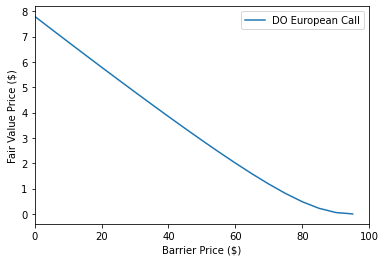

In [25]:
# plt.plot(smax_values, s_max_am_call, label="Vanilla American Call")
plt.plot(barrier_values, do_call_barrier_test, label="DO European Call")
# plt.xscale('log')
plt.ylabel('Fair Value Price ($)')
plt.xlabel('Barrier Price ($)')
plt.xlim([0,100])
plt.legend()
plt.show()